In [6]:
import json
import numpy as np
import matplotlib.pyplot as plt
# depending on what's installed, might need a different backend
#plt.switch_backend('WebAgg')
from scipy.stats import mstats

model_path = '../../trained_models/b_lenet_cifar10.pth'
model_name = "b_lenet_cifar"
data_set = "cifar10"
device = 'cuda:1'

# json_file = "./rawSoftmax_b_lenet_se_singleThresh_2023-07-19_153525.json"
# FIXME MISSING -> json_file = "../../model-outputs/b_lenet_cifar_singleThresh_2023-07-20_161032.json"
#json_file = "../../model-outputs/b_lenet_cifar_singleThresh_2023-07-20_172520.json"
json_file = f'../../model-outputs/{model_name}/cifar10_raw_train_output_2025-01-14_144838.json'

with open(json_file) as json_data:
    data = json.load(json_data)

#data

In [9]:
# these are the ground truth values
true_vals = data['true_indices']
print(len(true_vals))

# OLD
#true_vals = data['test_vals']['true_indices']

40000


In [10]:
# OLD
#num_exits = data['test_vals']['num_exits']
#num_compares = len(data['test_vals']['comps'])

num_exits = data['num_exits']
num_compares = len(data['conf_metrics'].keys())

# num_exits x num_samples x num_classes

#sftmx = data['test_vals']['comps'][1]['raw_softmax']
#sftmx = np.array(sftmx)
# NOTE NOT BLOODY USED

not skipping entropy
not skipping max_softmax
not skipping max_softmax_fast
not skipping max_softmax_fast_noTrunc
not skipping max_softmax_fast_sub
Found a sub! max_softmax_fast_sub
Found a sub! max_softmax_fast_sub
not skipping max_softmax_fast_sub_bitAcc
Found a sub! max_softmax_fast_sub_bitAcc
Found a sub! max_softmax_fast_sub_bitAcc


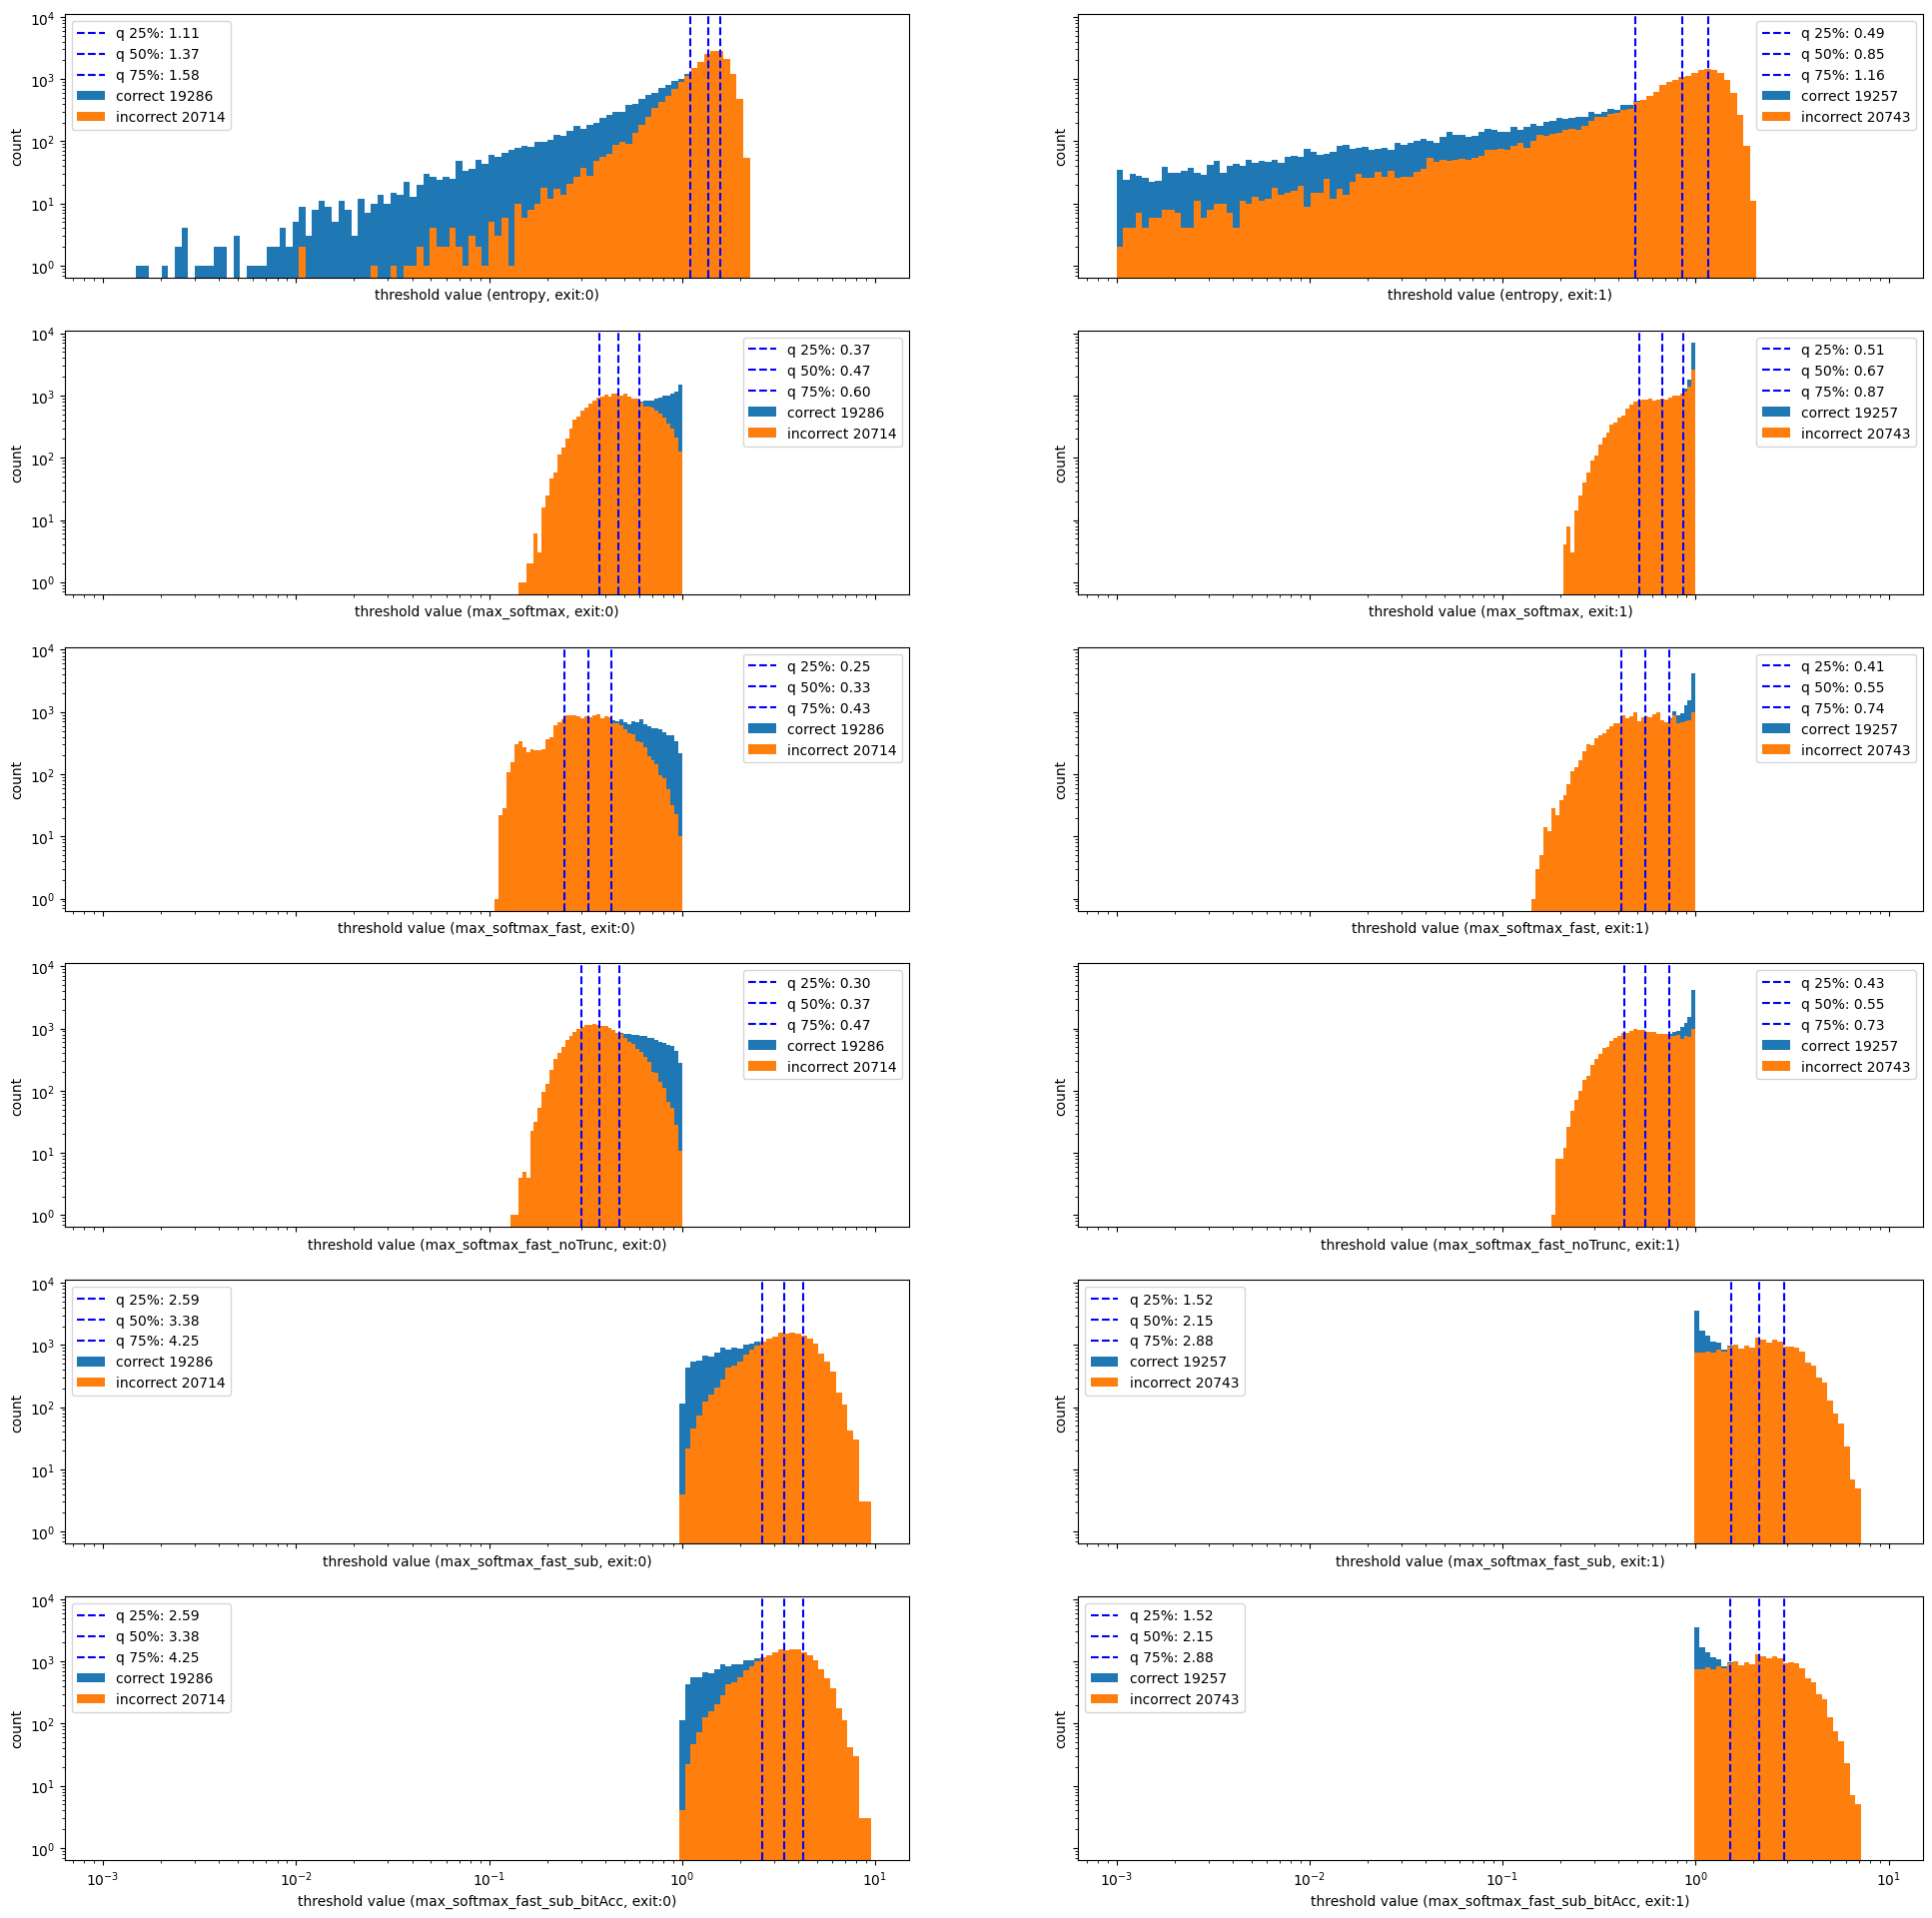

In [25]:
#%matplotlib widget

# The short version, we want these plots to be the same or very close.
# This means that the effect of changing base and quantisation will
# have had a minimal effect on the resulting values used to threshold
# the early exit

fig, ax_grp = plt.subplots(nrows=num_compares, ncols=num_exits, sharey=True, sharex=True)

# discern between correctly classified values and not
correctness = np.array(data['raw_layer']).argmax(-1) == true_vals

#for row, func in enumerate(data['test_vals']['comps']):
for row, func in enumerate(data['conf_metrics'].keys()):
    #if row == 0:
        # NOTE jthis particular file, entropy results were not recorded correctly?
        # ../../model-outputs/b_lenet_cifar_singleThresh_2023-07-20_172520.json
        # the entropy plot would be different anyway? since the inequality is reversed
        #print('skipping entropy')
        #continue
    f_name = func[5:] #str(data['conf_metrics'][func])
    print(f'not skipping {f_name}')
    
    #raw_softmax_per_exit = np.array(data['test_vals']['comps'][row]['raw_softmax'])
    raw_softmax_per_exit = np.array(data['conf_metrics'][func]['raw_softmax'])
    for exit_num in range(raw_softmax_per_exit.shape[0]):
    
        ax = ax_grp[row][exit_num]
    
        # FIXME not sure if correctness should be conditionalled on the "raw softmax" values
        # means smth different for entropy and sub confidence metrics
        #correctness = np.argmax(raw_softmax_per_exit[exit_num], -1) == true_vals
        
        # separate the maximum values for the correct and incorrect
        maxsoftmax = np.max(raw_softmax_per_exit[exit_num], -1)
        
        #logbins = np.logspace(np.log10(0.001),np.log10(1),100)
        if "entropy" in func.lower():                                                                                 
            maxsoftmax = raw_softmax_per_exit[exit_num]                                                 
            logbins = np.logspace(np.log10(0.001), np.log10(max( maxsoftmax )), 100)                         
            gt_inequality_bool = False                                           
        elif "sub" in func.lower():                                          
            print(f"Found a sub! {f_name}")                                        
            # the max value will always be 1 by design...                        
            # need to use the sum instead I think?                               
            # since the threshold is 1 > thr * sum                               
            maxsoftmax = np.sum(raw_softmax_per_exit[exit_num], axis=-1)
            logbins = np.logspace(np.log10(0.01), np.log10(max( maxsoftmax )), 100)
            gt_inequality_bool = False                                                
        else:                                                                    
            maxsoftmax = np.max(raw_softmax_per_exit[exit_num], -1)          
            logbins = np.logspace(np.log10(0.01),np.log10(1),100)

        # NOTE command nukes jupyter vvv unsure why
        correct_vals = maxsoftmax[correctness[exit_num]]
        wrong_vals = maxsoftmax[np.invert(correctness[exit_num])]
        
        quants = [0.25, 0.5, 0.75]
        quantiles = mstats.mquantiles(wrong_vals, prob=quants)
        for i, q in enumerate(quantiles):
            ax.axvline(q, 0, color='b', ls='--', label=f"q {quants[i]*100:.0f}%: {q:.02f}")

        ax.hist(correct_vals, bins=logbins, label=f'correct {len(correct_vals)}')      
        ax.hist(wrong_vals, bins=logbins, stacked=True, label=f'incorrect {len(wrong_vals)}')
        ax.set_xlabel(f'threshold value ({f_name}, exit:{exit_num})')
        ax.set_ylabel('count')
        ax.legend()
        
        # NOTE for some reason these cause kernel to hang
        # turns out the old version of plt couldn't handle zero sized bins with log scaling
        ax.set_yscale('log')
        ax.set_xscale('log')

fig.set_size_inches(12 * num_exits, 4 * num_compares)
plt.show()